# Transmission, reflection and refraction

In this notebook we will think briefly about ray-tracing with refraction.  You should read
around other topic in seismic wave propagation including surface waves,
basin effects and anisotropy. This notebook will again be very light on theory, and will focus
on playing with data.  In the previous notebook we have already seen some of the effects of
transmission, reflection and refraction.

Topics to read around:
- Surface waves
- Basin effects (resonance)
- Spectral ratios
- Anisotropy
- Spherical attenuation
- Scattering
- Dispersion around objects
- Phase and group velocities of surface waves
- Surface wave dispersion and what it tells us about velocities variations with depth
    - How we can use seismic noise to provide velocity information.
- Normal modes

## Basic ray-tracing with refraction

The code below constitutes a very basic ray-tracer implementing only Snell's Law (no reflection,
no Huygen's) in a flat Earth. Think about the issues with this code - there are simple
physics issues as well as programmatic limitations to this that mean that a downgoing ray
should never return to the surface.

190.00 thick model of 190 layers


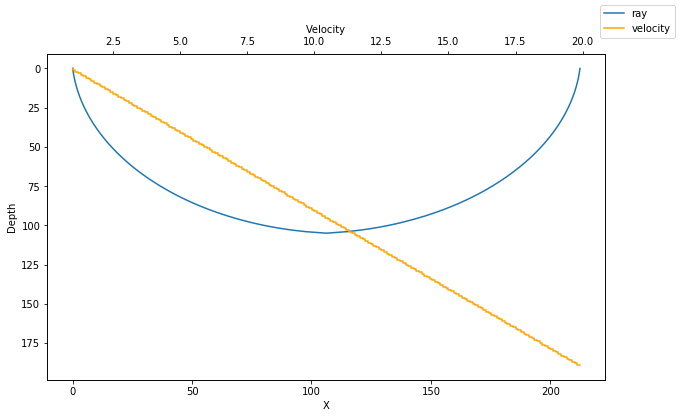

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np


class ModelLimitError(Exception):
    """Error when we run out of model."""
    def __init__(self, value):
        self.value = value


class Layer(object):
    """
    A simple velocity model layer.
    
    :type thickness: float
    :param thickness: The thickness of the layer in km
    :type velocity: float
    :param velocity: 
        The velocity of the layer in km/s (not speficialy P or S-wave.)
    """
    def __init__(self, thickness, velocity):
        self.thickness = thickness
        self.velocity = velocity
        
    def __str__(self):
        return "Layer(thickness={0}, velocity={1})".format(
            self.thickness, self.velocity)
    
    def __repr__(self):
        return self.__str__()
    
    def trace(self, x_in, angle_in, time_in=0, orientation="RIGHT"):
        """
        Trace a ray through this layer from some x location and
        some incidence angle.
        
        :type x_in: float
        :param x_in: Horizontal position of incoming ray
        :type angle_in: float
        :param angle_in: Incoming angle of ray in radians
        :type time_in: float
        :param time_in: Time in seconds for ray coming into layer
        :type orientation: str
        :param orientation: 
            Either "RIGHT" or "LEFT" depending on which way the ray is going.
            
        :returns: tuple of horizontal position out and time out.
        """
        hyp = self.thickness / math.cos(angle_in)
        time_out = time_in + (hyp / self.velocity)
        if orientation == "RIGHT":
            x_out = x_in + (hyp * math.sin(angle_in))
        else:
            x_out = x_in - (hyp * math.sin(angle_in))
        return x_out, time_out


def snells_law(v1, v2, angle_in):
    """
    Simple implemenation of Snell's law for refraction between two layers of
    different velocities. Ray is traced from layer 1 to layer 2.
    
    :type v1: float
    :param v1: Velocity of layer 1 in km/s
    :type v2: float
    :param v2: Velocity of layer 2 in km/s
    :type angle_in: float
    :param angle_in: Incidence angle in radians
    
    :returns: angle out in radians.
    """
    a = (math.sin(angle_in) * float(v2)) / float(v1)
    return math.asin(a)


class Model(object):
    """
    Velocity model of 1D layers of constant velocity.
    
    :type layers: list
    :param layers: 
        Ordered list of Layer objects for velocity model, ordered
        from layers[0] at the surface.
    """
    def __init__(self, layers):
        """Ordered list of layers, with surface first."""
        if isinstance(layers, list):
            self.layers = layers
        else:
            self.layers = [layers]
        self.thickness = sum([layer.thickness for layer in self.layers])
        self.n_layers = len(self.layers)
        depth = 0
        self.depths = [depth]
        for layer in self.layers:
            depth += layer.thickness
            self.depths.append(depth)
    
    def __str__(self):
        return "{0:.2f} thick model of {1:d} layers".format(
            self.thickness, self.n_layers)
    
    def __repr__(self):
        return self.__str__()
    
    def _get_layer(self, depth, direction):
        if direction.upper() not in ["UP", "DOWN"]:
            raise NotImplementedError("direction must be either up or down")
        if depth > self.depths[-1]:
            raise ModelLimitError("Hit the edge of the model")
        for i in range(self.n_layers):
            layer_top = self.depths[i]
            layer_bottom = self.depths[i + 1]
            if layer_top < depth < layer_bottom:
                # We are in this layer, but we don't want all the layer
                if direction.upper() == "DOWN":
                    thickness = layer_bottom - depth
                else:
                    thickness = depth - layer_top
                return Layer(thickness=thickness, 
                             velocity=self.layers[i].velocity), i
            elif depth == layer_top:
                if direction.upper() == "DOWN":
                    return self.layers[i], i
                elif i > 0:
                    return self.layers[i - 1], i - 1
                else:
                    raise ModelLimitError(
                        "No more layers above {0}".format(depth))
            elif depth == layer_bottom:
                if direction.upper() == "UP":
                    return self.layers[i], i
                elif i < self.n_layers - 1:
                    return self.layers[i + 1], i + 1
                else:
                    raise ModelLimitError(
                        "No more layers below {0}".format(depth))
        else:
            print("Depth: {0} Layer top: {1}, Layer bottom: {2}".format(
                depth, layer_top, layer_bottom))
            raise NotImplementedError("Something happened at depth {0}".format(depth))
    
    def trace_rays(self, source_x, source_depth, angular_range=(1, 90), xlim=None):
        """
        Trace rays through the Model from a given source and plot them.
        
        :type source_x: float
        :param source_x: Horizontal location of source in km
        :type source_depth: float
        :param source_depth: Source depth in km
        :type angular_range: tuple
        :param angular_range: 
            Tuple of (start, stop) for the range of angles in degrees to trace rays.
            Optionally add a step (start, stop, step) to change the increment between
            angles.
        :type xlim: float
        :param xlim: Horizontal limit to trace rays to.
        
        :returns: Figure.
        
        +ve angle is downgoing ray.
        
        Geometry is:
            180
             |
        -90-src-90
             |
             0
        """
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6),
                                 sharex=True)
        ax1 = axes[0]
        times, distances = ([], [])
        for take_off_angle in np.arange(*angular_range):
            x, z, t = self.trace_ray(
                source_x=source_x, take_off_angle=take_off_angle,
                source_depth=source_depth)
            if z[-1] == 0:
                if xlim and xlim[0] < x[-1] < xlim[1]:
                    # If it gets to the surface, plot it
                    times.append(t[-1])
                    distances.append(x[-1])
                elif xlim is None:
                    times.append(t[-1])
                    distances.append(x[-1])
            ax1.plot(x, z, color="C0")
        ax2 = ax1.twiny()
        ax2.step([0] + [layer.velocity for layer in self.layers],
                 [0] + self.depths[0:-1], "orange", label="velocity")
        ax2.set_xlabel("Velocity")
        ax1.invert_yaxis()
        ax1.set_xlabel("X")
        ax1.set_ylabel("Depth")
        axes[1].scatter(distances, times)
        axes[1].set_ylabel("Time(s)")
        axes[1].set_xlabel("X")
        if xlim is not None:
            axes[1].set_xlim(xlim)
        fig.subplots_adjust(hspace=0)
        fig.legend()
        return fig
    
    def trace_ray(self, source_x, take_off_angle, source_depth=0,
                  plot=False, fig=None):
        """
        Trace a single ray from the surface through the model.
        
        :type source_x: float
        :param source_x: Horizontal starting position in km
        :type take_off_angle: float
        :param take_off_angle: Take-off angle in degrees
        :type source_depth: float
        :param source_depth: Source depth in km
        :type plot: bool
        :param plot: Whether to plot the result or not
        :type fig: matplotlib.pyplot.Figure
        :param fig: Figure to plot into, or None to make a new figure.
        
        :returns: 
            tuple of arrays of horizontal positions, depths and times 
            (and figure if plot=True)
        
        +ve angle is downgoing ray.
        
        Geometry is:
            180
             |
        -90-src-90
             |
             0
        """
        orientation = "RIGHT"
        if -90 < take_off_angle < 90:
            direction = "DOWN"
            if take_off_angle < 0:
                orientation = "LEFT"
                take_off_angle = abs(take_off_angle)
        elif 90 < take_off_angle < 270:
            direction = "UP"
            if take_off_angle > 180:
                take_off_angle -= 180
                orientation = "LEFT"
            else:
                take_off_angle = abs(take_off_angle - 180)
        else:
            raise NotImplementedError(
                "take_off_angle should be between -90 and 270, but not be 0")
        time = 0
        x_loc = source_x
        depth = source_depth
        incidence_angle = math.radians(take_off_angle)
        x_positions, times, z_positions = ([x_loc], [time], [depth])
        
        while True:
            x_positions.append(x_loc)
            times.append(time)
            z_positions.append(depth)
            try:
                layer, layer_number = self._get_layer(depth, direction)
            except ModelLimitError as e:
                # Hit the edge of our model, we should stop
                break          
            x_loc, time = layer.trace(
                x_loc, incidence_angle, time, orientation=orientation)
            if direction == "DOWN":
                depth += layer.thickness
            else:
                depth -= layer.thickness
            # Re-calculate the angle using Snell's
            if direction == "UP":
                try:
                    next_layer = self.layers[layer_number - 1]
                except IndexError:
                    break
            else:
                try:
                    next_layer = self.layers[layer_number + 1]
                except IndexError:
                    break
            try:
                incidence_angle = snells_law(
                    layer.velocity, next_layer.velocity, 
                    incidence_angle)
            except ValueError:
                if incidence_angle < math.radians(90):
                    direction = "UP"
                else:
                    raise NotImplementedError(
                        "Don't know what happened here, incidence angle: "
                        "{0}".format(incidence_angle))
        x_positions.append(x_loc)
        times.append(time)
        z_positions.append(depth)
        
        if plot is True:
            if fig is None:
                fig, ax = plt.subplots(1, figsize=(10, 6))
            else:
                ax = fig.gca()
            ax.plot(x_positions, z_positions, label="ray")
            ax2 = ax.twiny()
            ax2.step([layer.velocity for layer in self.layers],
                     self.depths[0:-1], "orange", label="velocity")
            ax2.set_xlabel("Velocity")
            ax.invert_yaxis()
            ax.set_xlabel("X")
            ax.set_ylabel("Depth")
            fig.legend()
            return x_positions, z_positions, times, fig
        return x_positions, z_positions, times
    
velocity_step = 0.1
thickness = velocity_step * 10
linear_model = Model(
    layers=[Layer(thickness=thickness, velocity=v) 
            for v in np.arange(1., 20., velocity_step)])
print(linear_model)

x_positions, depths, times, fig = linear_model.trace_ray(0., 5., plot=True)

The code deliberately reflects when the ray gets close to total internal reflection due to numerical
instability. This artificially introduces a ray that returns to the surface in this model.
Above we have a discretised constant velocity gradient, which is quite dull.

**Question:** What parameter would you include in this code for a spherical Earth?

*Response:*

**Exercise:** Try some other velocity models, with steps, different gradients, and combinations of steps and gradients, an example of a stepped velocity model is shown below, adapt this:

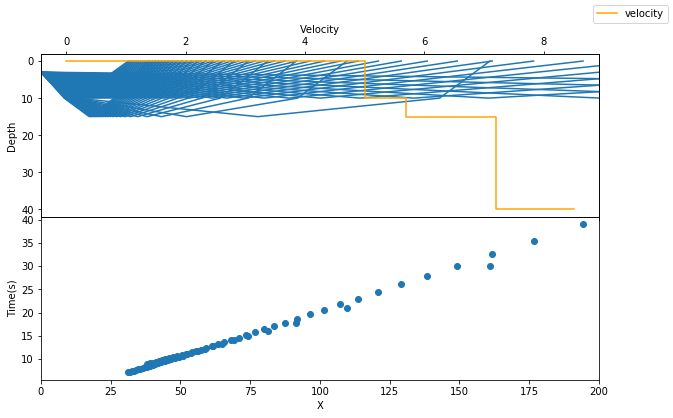

In [2]:
# Answer
stepped_model = Model(
    layers=[
        Layer(thickness=10, velocity=5),
        Layer(thickness=5, velocity=5.7),
        Layer(thickness=25, velocity=7.2),
        Layer(thickness=50, velocity=8.5)
    ])

fig = stepped_model.trace_rays(
    source_x=0, source_depth=3., angular_range=(50, 90, 0.5),
    xlim=(0, 200))